In [1]:
import xarray as xr

In [2]:
ds_disk = xr.open_dataset("/Users/seanharkins/projects/gridmet_testing/cache/00f2517fea10e432202fcfd8ce493714-https_www.northwestknowledge.net_metdata_data_srad_1999.nc")

In [3]:
ds_disk

<xarray.Dataset>
Dimensions:                                    (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon                                        (lon) float64 -124.8 ... -67.06
  * lat                                        (lat) float64 49.4 ... 25.07
  * day                                        (day) datetime64[ns] 1999-01-0...
  * crs                                        (crs) uint16 3
Data variables:
    surface_downwelling_shortwave_flux_in_air  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       03 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [4]:
pdsi_disk = xr.open_dataset("/Users/seanharkins/Downloads/pdsi.nc")

In [5]:
pdsi_disk

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, day: 3040, crs: 1)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * day      (day) datetime64[ns] 1980-01-05 1980-01-10 ... 2021-08-23
  * crs      (crs) uint16 3
Data variables:
    pdsi     (day, lat, lon) float32 ...
Attributes: (12/23)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       2980
    last_early_slice:           3040
    last_provisional_slice:     3034
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [6]:
pdsi_1 = pdsi_disk.sel(day=slice('1998-01-01', '1998-12-31'))
pdsi_1

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, day: 73, crs: 1)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * day      (day) datetime64[ns] 1998-01-05 1998-01-10 ... 1998-12-31
  * crs      (crs) uint16 3
Data variables:
    pdsi     (day, lat, lon) float32 ...
Attributes: (12/23)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       2980
    last_early_slice:           3040
    last_provisional_slice:     3034
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [7]:
from pangeo_forge_recipes.patterns import ConcatDim, FilePattern, MergeDim
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

In [8]:
# Filename Pattern Inputs
target_chunks = {"lat": 512, "lon": 512, "time": 30}
years = list(range(1998, 2000))
variables = [
    "sph",
    "vpd",
    "pr",
    "rmin",
    "rmax",
    "srad",
    "tmmn",
    "tmmx",
    "vs",
    "th",
    "pet",
    "etr",
    "bi",
    "fm100",
    "fm1000",
]


def make_filename(variable, time):
    if variable == "pdsi":
        filename = "https://www.northwestknowledge.net/metdata/data/pdsi.nc"
    else:
        filename = f"https://www.northwestknowledge.net/metdata/data/{variable}_{time}.nc"  # noqa: E501
    return filename


pattern = FilePattern(
    make_filename, ConcatDim(name="time", keys=years), MergeDim(name="variable", keys=variables)
)


In [9]:
def preproc(ds, filename):
    """custom preprocessing function for gridMET data"""

    rename = {}

    station_influence = ds.get("station_influence", None)

    if station_influence is not None:
        ds = ds.drop_vars("station_influence")
        
    var = list(ds.data_vars)[0]

    #  if var in rename_vars:
        #  rename[var] = rename_vars[var]

    if "day" in ds.coords:
        rename["day"] = "time"
        
    if station_influence is not None:
        ds[f"{var}_station_influence"] = station_influence

    #  with xr.set_options(keep_attrs=True):
        #  ds[var] = apply_mask(var, ds[var])

    if rename:
        ds = ds.rename(rename)

    return ds


In [10]:
# Recipe Inputs
recipe = XarrayZarrRecipe(
    file_pattern=pattern,
    target_chunks=target_chunks,
    process_input=preproc,
    subset_inputs={"time": 3},
)

In [11]:
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2, 'variable': 15}>, inputs_per_chunk=1, target_chunks={'lat': 512, 'lon': 512, 'time': 30}, target=None, input_cache=None, metadata_cache=None, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=<function preproc at 0x11e4cb790>, process_chunk=None, lock_timeout=None, subset_inputs={'time': 3}, is_opendap=False)

In [12]:
import logging
logger = logging.getLogger("pangeo_forge_recipes")
formatter = logging.Formatter('%(name)s:%(levelname)s - %(message)s')
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
handler.setFormatter(formatter)
logger.setLevel(logging.INFO)
logger.addHandler(handler)

In [13]:
all_chunks = list(recipe.iter_chunks())
len(all_chunks)

90

In [14]:
%xmode minimal
with recipe.open_chunk(all_chunks[10]) as ds:
    display(ds)

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0,variable-3,time-1
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-3: 'https://www.northwestknowledge.net/metdata/data/rmin_1998.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.northwestknowledge.net/metdata/data/rmin_1998.nc' directly.


Exception reporting mode: Minimal


pangeo_forge_recipes.recipes.xarray_zarr:INFO - Subsetting input according to time-1
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0,variable-3,time-1'


<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, time: 121, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * time               (time) datetime64[ns] 1998-05-02 ... 1998-08-30
  * crs                (crs) uint16 3
Data variables:
    relative_humidity  (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       03 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [15]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge_recipes.storage import FSSpecTarget, CacheFSSpecTarget, MetadataTarget

fs_local = LocalFileSystem()

cache_dir = "/Users/seanharkins/projects/gridmet_testing/cache"
cache_target = CacheFSSpecTarget(fs_local, cache_dir)

target_dir = "/Users/seanharkins/projects/gridmet_testing/target.zarr"
target = FSSpecTarget(fs_local, target_dir)

meta_dir = "/Users/seanharkins/projects/gridmet_testing/metadata"
meta_target = MetadataTarget(fs_local, meta_dir)

recipe.input_cache = cache_target
recipe.target = target
recipe.metadata_cache = meta_target
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2, 'variable': 15}>, inputs_per_chunk=1, target_chunks={'lat': 512, 'lon': 512, 'time': 30}, target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x11e564e80>, root_path='/Users/seanharkins/projects/gridmet_testing/target.zarr'), input_cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x11e564e80>, root_path='/Users/seanharkins/projects/gridmet_testing/cache'), metadata_cache=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x11e564e80>, root_path='/Users/seanharkins/projects/gridmet_testing/metadata'), cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=<function preproc at 0x11e4cb790>, process_chunk=None, lock_timeout=None, subset_inputs={'time': 3}, is_opendap=False)

In [16]:
with recipe.open_chunk(all_chunks[0]) as ds:
    display(ds)
    # need to load if we want to access the data outside of the context
    ds.load()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0,variable-0,time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-0: 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Subsetting input according to time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0,variable-0,time-0'


<xarray.Dataset>
Dimensions:            (lon: 1386, lat: 585, time: 121, crs: 1)
Coordinates:
  * lon                (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * time               (time) datetime64[ns] 1998-01-01 ... 1998-05-01
  * crs                (crs) uint16 3
Data variables:
    specific_humidity  (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       03 July 2019
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [26]:
print(f'Input chunk size: {ds.nbytes / 1e6} MB')

Input chunk size: 392.448778 MB


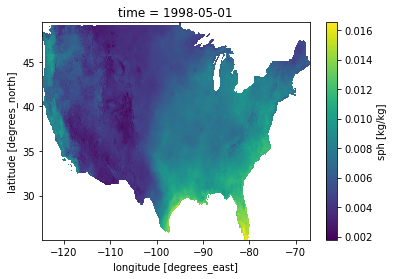

In [18]:
ds.specific_humidity[-1].plot()

In [19]:
from pangeo_forge_recipes.recipes.xarray_zarr import cache_input_metadata

for input_name in recipe.iter_inputs():
    cache_input_metadata(
        input_name,
        file_pattern=recipe.file_pattern,
        input_cache=recipe.input_cache,
        cache_inputs=recipe.cache_inputs,
        copy_input_to_local_file=recipe.copy_input_to_local_file,
        xarray_open_kwargs=recipe.xarray_open_kwargs,
        delete_input_encoding=recipe.delete_input_encoding,
        process_input=recipe.process_input,
        metadata_cache=recipe.metadata_cache,
        is_opendap=False,
    )

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching metadata for input 'time-0,variable-0'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-0: 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching metadata for input 'time-0,variable-1'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-1: 'https://www.northwestknowledge.net/metdata/data/vpd_1998.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.northwestknowledge.net/metdata/data/vpd_1998.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Caching metadata for input 'time-0,variable-2'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-2: 'https://www.northwestknowledge.net/metdata/data/pr_1998.nc'
pangeo_forge_reci

In [20]:
recipe.prepare_target()

/Users/seanharkins/projects/gridmet_testing/venv/lib/python3.9/site-packages/pangeo_forge_recipes/recipes/xarray_zarr.py:107: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Creating a new dataset in target
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0,variable-0,time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-0: 'https://www.northwestknowledge.ne

In [21]:
for chunk in recipe.iter_chunks():
    recipe.store_chunk(chunk)
recipe.finalize_target()

pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0,variable-0,time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening input with Xarray time-0,variable-0: 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc'
pangeo_forge_recipes.storage:INFO - Opening 'https://www.northwestknowledge.net/metdata/data/sph_1998.nc' from cache
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Subsetting input according to time-0
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Combining inputs for chunk 'time-0,variable-0,time-0'
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable time chunk time-0,variable-0,time-0 to Zarr region (slice(0, 121, None),)
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Storing variable specific_humidity chunk time-0,variable-0,time-0 to Zarr region (slice(0, 121, None), slice(None, None, None), slice(None, None, None))
pangeo_forge_recipes.recipes.xarray_zarr:INFO - Opening inputs for chunk time-0,variable-0,time-1
pange

In [22]:
ds_target = xr.open_zarr(target.get_mapper(), consolidated=True)
ds_target


<xarray.Dataset>
Dimensions:                                    (time: 730, lat: 585, lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 3
  * lat                                        (lat) float64 49.4 ... 25.07
  * lon                                        (lon) float64 -124.8 ... -67.06
  * time                                       (time) datetime64[ns] 1998-01-...
Data variables:
    air_temperature                            (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 dask.array<chunksize=(30, 512, 512), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       03 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [23]:
print(f'{ds_target.nbytes / 1e9} GB')

28.41080401 GB


In [24]:
air = ds_target.air_temperature.isel(lat=60, lon=50)


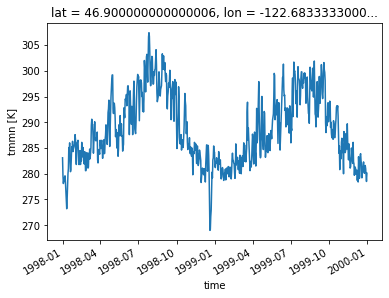

In [25]:
air.plot()